# Trying Binary Image Classification
Let's investigate the image set, simply by differentiating between images with 'No Finding' set to 1 from those without that setting.

In [15]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load `train.csv` and `valid.csv` files. Note: here, you'll notice that I have `train_plusMeta.csv`, which is a modified version of the original file to include PID and StudyID as separate columns.

In [16]:
train = pd.read_csv('./data/chexpert/train_plusMeta.csv')
train_frontal = train[train['Frontal/Lateral']=='Frontal']
valid = pd.read_csv('./data/chexpert/valid_plusMeta.csv')
valid_frontal = valid[valid['Frontal/Lateral']=='Frontal']
valid_frontal.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,PID,StudyID
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64541,1
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64542,1
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64543,1
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64544,1
5,CheXpert-v1.0-small/valid/patient64545/study1/...,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,64545,1


Load training data with appropriate labels

In [17]:
IMG_SIZE = 300
imageDirRoot = 'C:/Users/3169dobbsp/Documents/'

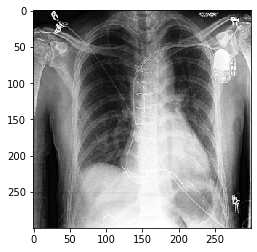

In [19]:
train_dat = []
sample = train_frontal.sample(n=1000,random_state=1)
for index, row in sample.iterrows():
    label = np.array([1,0])
    if row['No Finding']==1:
        label = np.array([0,1])
    filepath = os.path.join(imageDirRoot,row['Path'])
    img = Image.open(filepath)
    img = img.convert('L')
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    train_dat.append([np.array(img), label])

plt.imshow(train_dat[22][0], cmap = 'gist_gray')

Import all necessary libraries for image classification

In [20]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 

ModuleNotFoundError: No module named 'keras'

### Make Model from Scratch

In [ ]:
model = Sequential()
model.add(Conv2D(16, 5, padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
trainImages = np.array([i[0] for i in train_dat]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in train_dat])
model.fit(trainImages, trainLabels, batch_size = 32, epochs = 10, verbose = 1)

#### Test on the validation data

In [ ]:
valid_dat = []
sample = valid_frontal.sample(n=100,random_state=1)
for index, row in sample.iterrows():
    label = np.array([1,0])
    if row['No Finding']==1:
        label = np.array([0,1])
    filepath = os.path.join(imageDirRoot,row['Path'])
    img = Image.open(filepath)
    img = img.convert('L')
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    valid_dat.append([np.array(img), label])

plt.imshow(valid_dat[28][0], cmap = 'gist_gray')

In [ ]:
testImages = np.array([i[0] for i in valid_dat]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
testLabels = np.array([i[1] for i in valid_dat])

loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

The Following Cell Is Optional

In [ ]:
batch_size=32
seed=42
# use generator for training data
image_gen_train = ImageDataGenerator(
                    rescale=1./255.,
                    rotation_range=10,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.1
                    )
train_data_gen = image_gen_train.flow_from_dataframe(
                    dataframe = train_frontal,
                    directory=imageDirRoot,
                    x_col="Path",
                    y_col="No Finding",
                    shuffle=True,
                    batch_size=batch_size,
                    seed=seed
                    target_size=(IMG_SIZE,IMG_SIZE),
                    class_mode='sparse'
                    )

# use generator for validation data
image_gen_val = ImageDataGenerator(rescale=1./255.)
val_data_gen = image_gen_val.flow_from_dataframe(
                    dataframe=valid_frontal,
                    directory=imageDirRoot,
                    x_col="Path",
                    y_col="No Finding",
                    shuffle=False,
                    batch_size=batch_size,
                    seed=seed
                    target_size=(IMG_SIZE,IMG_SIZE),
                    class_mode='sparse'
                    )
